
# **Skin Cancer Classification Model**


Done by:


*   Bahaa aldin muhammad 202320258
*   kamal thaer 202310289
*   Ahmad abdullah alsaadi 202320281
*   mohammed muntaser 202111209

Under the suprevision of: dr.salam fraihat

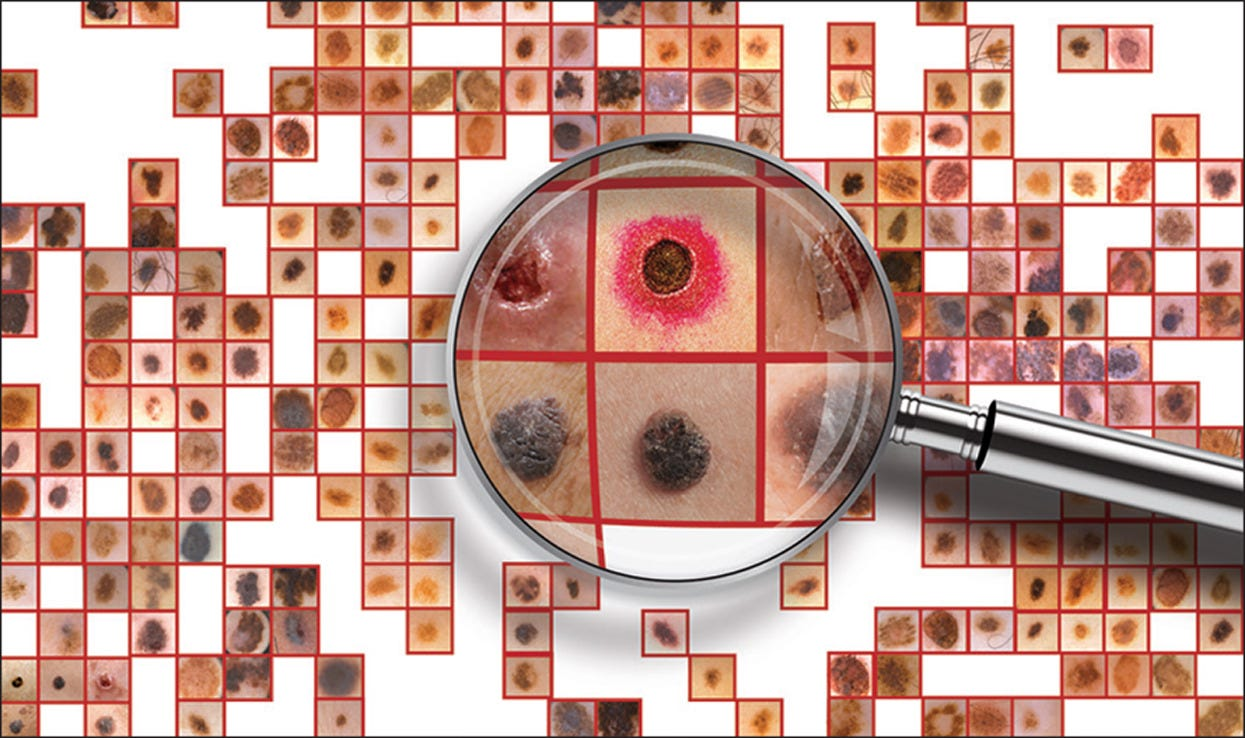

In [ ]:
#Importing all the neccesary tools
from google.colab import files
import os, pathlib, glob, random, zipfile
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, f1_score)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPooling2D, Input, Normalization, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet50v2_preprocess
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mbv2_preprocess
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

As the data is very large in size we will have to pull the dataset from Drive into the notebook Directly

In [ ]:
# Uploading the dataset
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thehound76","key":"fd654c54c0a7037ac3705b3b499056e9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

!mkdir -p data/ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d data/ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.13G/5.20G [00:11<00:00, 674MB/s]
100% 5.20G/5.20G [00:11<00:00, 503MB/s]


In [ ]:
# Disticting paths
META_PATH   = "/content/data/ham10000/HAM10000_metadata.csv"
IMAGES_PATH = "data/ham10000/images"

we want to check if all images are found and can be linked to the meta data that we have on hand



In [ ]:
ROOT_DIR = Path("/content/data/ham10000/images")
IMAGES_PARENT = ROOT_DIR

# recursively list images
def list_images(root: Path):
    exts = {".jpg"}
    files = [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts]
    return pd.DataFrame(
        [{"image_id": p.stem, "filepath": str(p)} for p in files])

meta = pd.read_csv(META_PATH)
meta = meta[meta["dx"].notna()].copy()

imgs = list_images(IMAGES_PARENT)

df = meta.merge(imgs, on="image_id", how="left")
missing = df.loc[df["filepath"].isna(), "image_id"].tolist()
extra   = sorted(set(imgs["image_id"]) - set(meta["image_id"]))

print(f"rows in metadata: {len(meta)}")
print(f"jpg on disk:      {len(imgs)}")
print(f"missing files:    {len(missing)}")
print(f"extra files:      {len(extra)}")

# keep only usable rows
df = df[df["filepath"].notna()].reset_index(drop=True)
df["image_path"] = df["filepath"]
print(f"usable rows after linkage: {len(df)}")

rows in metadata: 10015
jpg on disk:      10015
missing files:    0
extra files:      0
usable rows after linkage: 10015


We are gonna see the class distribution to check how many classes there are, and whether they're balanced or imbalanced

Rows: 10015

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

Class counts:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Number of classes: 7
Unique labels: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


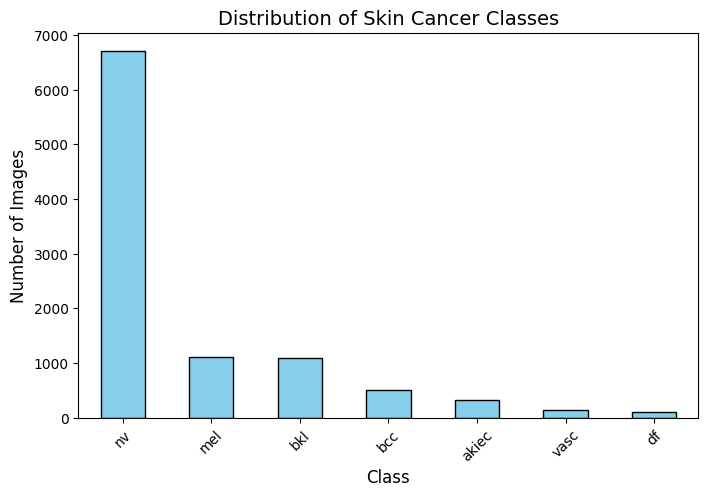

In [ ]:
df = pd.read_csv(META_PATH)
print("Rows:", len(df))
print("\nColumns:", df.columns.tolist())

print("\nClass counts:")
print(df['dx'].value_counts())
num_classes = df['dx'].nunique()
print("\nNumber of classes:", num_classes)
print("Unique labels:", df['dx'].unique().tolist())

plt.figure(figsize=(8,5))
df['dx'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of Skin Cancer Classes', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.show()


We are gonna take a look at what our data means and what each class stands for:



| Abbreviation | Full Name                                                           | Description                                                                                                                         |
| ------------ | ------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------- |
| **nv**       | **Melanocytic Nevus**                                               | Common moles caused by a benign growth of melanocytes. Usually uniform in color and shape; non-cancerous.                           |
| **mel**      | **Melanoma**                                                        | The most dangerous type of skin cancer; originates in melanocytes. Early detection is critical.                                     |
| **bkl**      | **Benign Keratosis-like Lesion**                                    | Includes seborrheic keratoses, solar lentigines, and lichen-planus-like keratoses. All are non-cancerous but may resemble melanoma. |
| **bcc**      | **Basal Cell Carcinoma**                                            | A common skin cancer arising from basal cells. Grows slowly and rarely spreads but can damage nearby tissue.                        |
| **akiec**    | **Actinic Keratosis / Intraepithelial Carcinoma (Bowen’s Disease)** | Precancerous or early-stage squamous cell carcinoma caused by sun damage. Needs monitoring or removal.                              |
| **vasc**     | **Vascular Lesion**                                                 | Includes angiomas, hemangiomas, and pyogenic granulomas. Typically benign and related to blood vessels.                             |
| **df**       | **Dermatofibroma**                                                  | A benign skin growth, often firm and slightly pigmented, resulting from minor trauma or insect bites.                               |


We will take a look at a couple of samples from each class so we can take a look at what they look like:

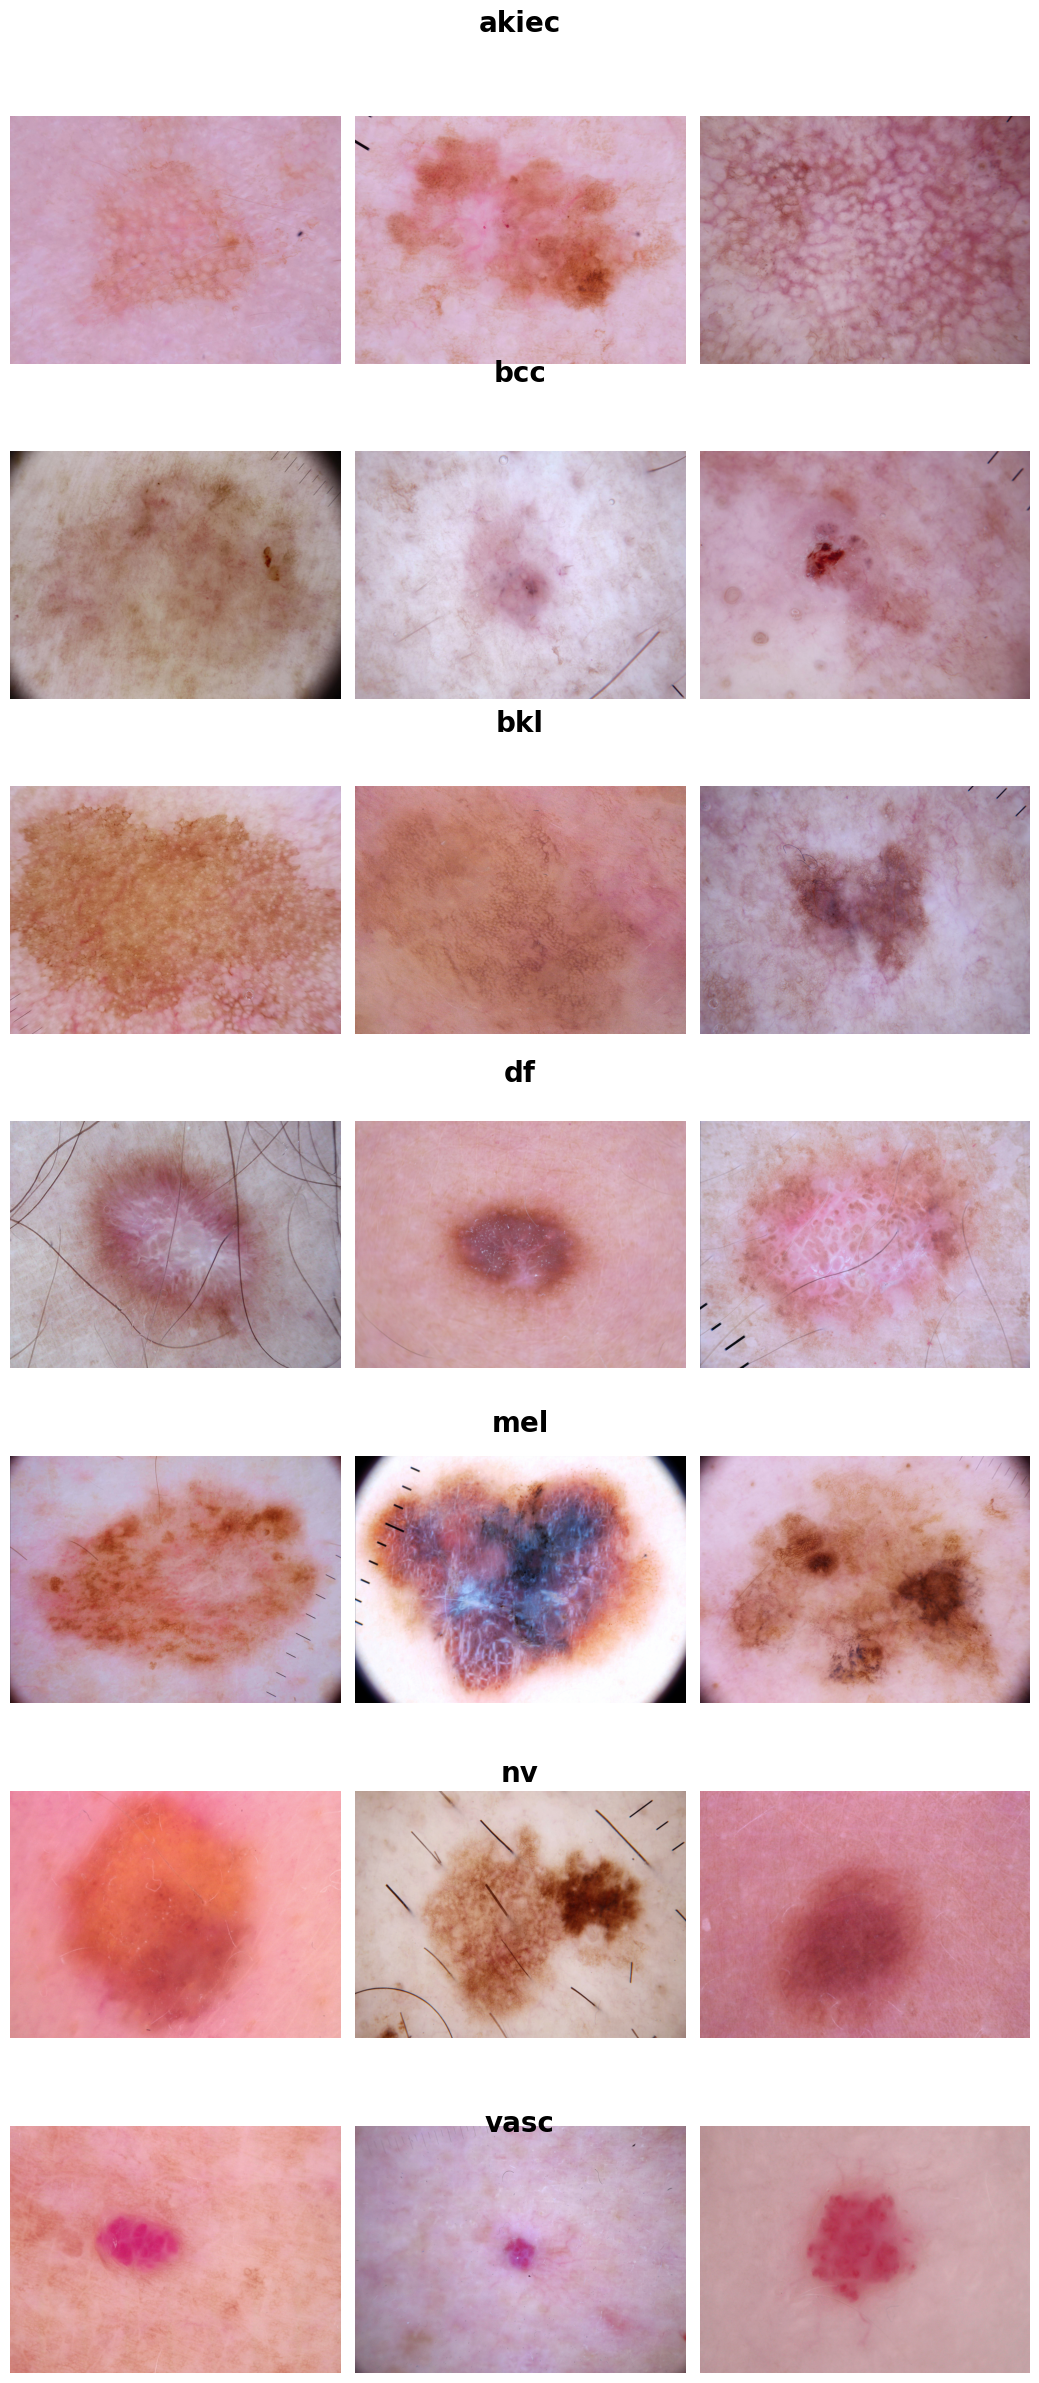

In [ ]:
N = 3
classes = sorted(df.loc[df["image_path"].notna(), "dx"].unique())

rows, cols = len(classes), N
fig, axes = plt.subplots(rows, cols, figsize=(3.5*cols, 3.5*rows))

for row_idx, cls in enumerate(classes):
    sub = df[(df["dx"] == cls) & df["image_path"].notna()].sample(N, random_state=42)

    for col_idx, (_, r) in enumerate(sub.iterrows()):
        ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]
        img = Image.open(r["image_path"]).convert("RGB")
        ax.imshow(img)
        ax.axis("off")


for row_idx, cls in enumerate(classes):
    y_pos = 1 - (row_idx + 0.5) / rows + 0.07
    fig.text(0.5, y_pos, cls, va='center', ha='center', fontsize=20, weight='bold')
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

we can clearly see that the data is heavily imbalanced, so if we train the model it will most likely be Biased towards the 'nv' class.

so we will be handling this issue in a bit.

In [ ]:
#Creating full paths for images so they can be accessed easily later
IMAGE_DIR_1 = '/content/data/ham10000/images/HAM10000_images_part_1'
IMAGE_DIR_2 = '/content/data/ham10000/images/HAM10000_images_part_2'

all_image_paths = {os.path.splitext(f)[0]: os.path.join(IMAGE_DIR_1, f)
                   for f in os.listdir(IMAGE_DIR_1)}
all_image_paths.update({os.path.splitext(f)[0]: os.path.join(IMAGE_DIR_2, f)
                        for f in os.listdir(IMAGE_DIR_2)})
df['image_path'] = df['image_id'].map(all_image_paths.get)

df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                            filepath  \
0  /content/data/ham10000/images/HAM10000_images_...   
1  /content/data/ham10000/images/HAM10000_images_...   
2  /content/data/ham10000/images/HAM10000_images_...   
3  /content/data/ham10000/images/HAM10000_images_...   
4  /content/data/ham10000/images/HAM10000_images_...   

                                          image_path  
0  /content/data/ham10000/images/HAM10000_images_...  
1  /content/data/ham10000/images/HAM10000_images_...  
2  /content/data/ham10000/images/HAM10000_images_...  
3  /content/data/ham10000/images/HAM10000_images_...  
4  /content/data/ham10000/images/HAM10000_images_...

this is to perform the train/test split:

In [ ]:
df_sane = df.copy()

# train/val/test = 70% / 15% / 15%
train_df, temp_df = train_test_split(
    df_sane, test_size=0.30, stratify=df_sane["dx"], random_state=42)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["dx"], random_state=42)

# keep only the columns we need for the generator
cols_needed = ["image_id", "dx", "image_path"]
train_df = train_df[cols_needed].reset_index(drop=True)
val_df   = val_df[cols_needed].reset_index(drop=True)
test_df  = test_df[cols_needed].reset_index(drop=True)

# Augumented data Generator
We will be applying **Data Augmentation** to our data so that we can bring the low count classes up to count and match the 'nv' class so that we can resolve the data imbalancing that we are facing.

Data Augmentation is the procces of slightly altering the data and reintroducing it to the model, like so:
we used the following Augmentations:


*   Rescale
*   horizontal flip
*   rotation
*   zoom
*   width shift
*   height shift
*   fill




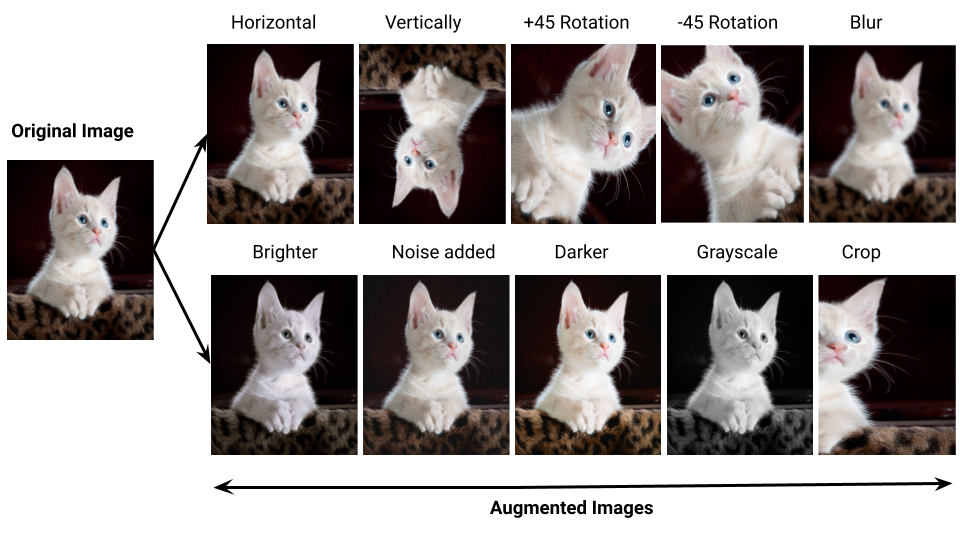

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  #Batch size was fixed here

# Augment only on training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,      # ~±45°
    zoom_range=0.1,
    brightness_range=None,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode="nearest")

# Validation/Test: no augmentation, only rescale
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="dx",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True)

val_gen = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="dx",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="dx",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False)

print(train_gen.class_indices)

Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


so now we are going to visualise our classes (during training) to see the difference.

We can see that the classes now have close counts and are balanced.

Basically the images are augmented in **real time**, during training, not saved permanently.

So instead of creating and storing thousands of rotated or flipped copies, the model gets a new random version of each image every time it trains.

Which means that the plot below is not real counts of images in each class, its more of an accurate representation of what the model expierences during training

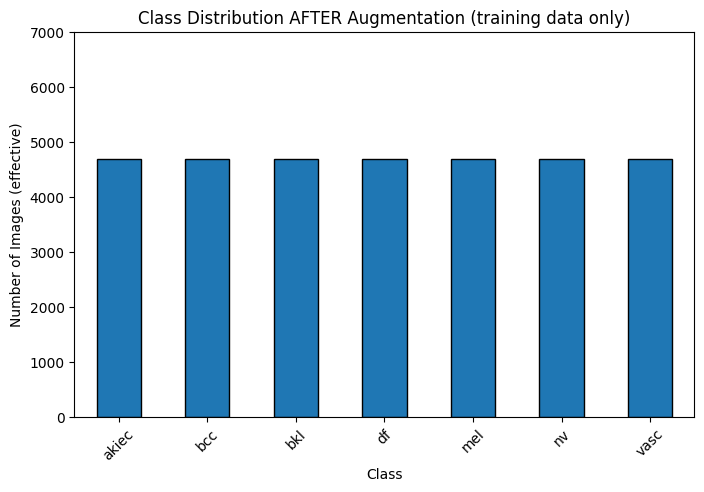

In [ ]:
orig_counts = train_df["dx"].value_counts().sort_index()
target_count = orig_counts.max()

balanced_parts = []
for cls, grp in train_df.groupby("dx"):
    reps = int(np.ceil(target_count / len(grp)))
    balanced_parts.append(pd.concat([grp]*reps).head(target_count))

balanced_train_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)


plt.figure(figsize=(8,5))
balanced_train_df["dx"].value_counts().sort_index().plot(kind="bar", edgecolor="black")
plt.title("Class Distribution AFTER Augmentation (training data only)")
plt.xlabel("Class")
plt.ylabel("Number of Images (effective)")
plt.xticks(rotation=45)
plt.ylim(0, 7000)
plt.show()

We are gonna display a few images so that the Viewr can get a clear idea of what the generator actually produced

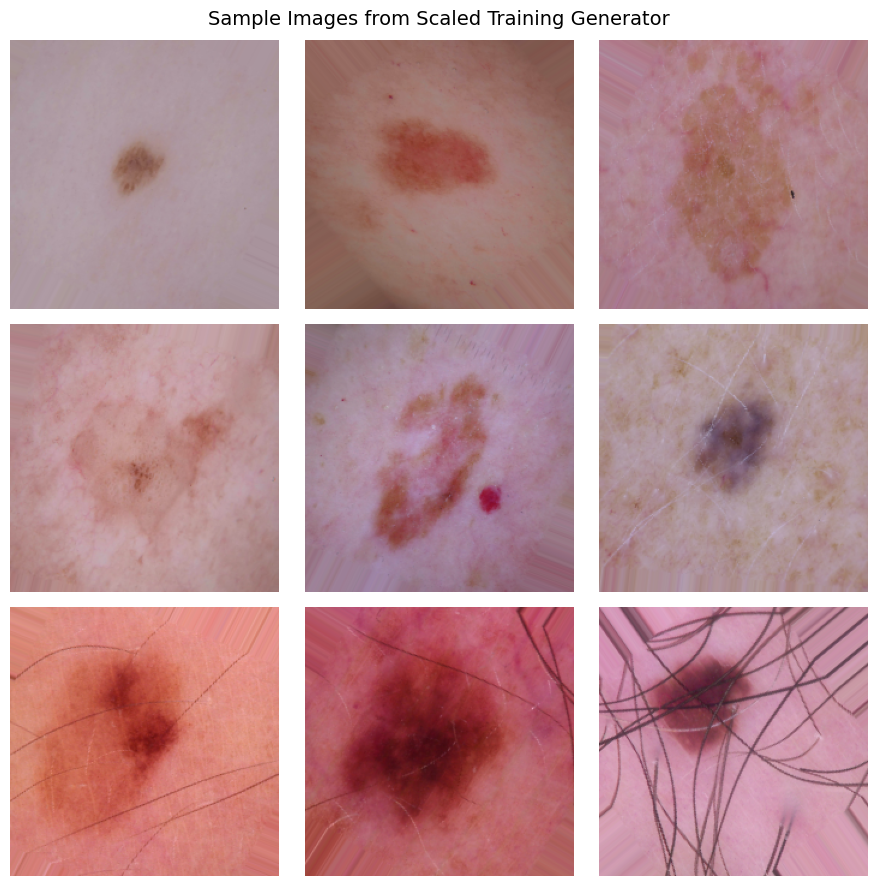

In [ ]:
images, labels = next(train_gen)

plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')

plt.suptitle("Sample Images from Scaled Training Generator", fontsize=14)
plt.tight_layout()
plt.show()

# Basic CNN model

we are gonna start things off with a basic Sequential CNN

In [ ]:
# we are gonna create our model then add layer by layer
model = Sequential()
#Layer 1
model.add(Conv2D(64, (3,3), input_shape = (224, 224, 3))) #Window size for sliding is 3x3
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
#Layer 2
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Layer 3
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.25))
# output Layer
model.add(Dense(7))
model.add(Activation("softmax"))

model.compile(loss = "categorical_crossentropy", optimizer ="adam",metrics =['accuracy'])

history = model.fit(train_gen,validation_data=val_gen,epochs = 40)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 554ms/step - accuracy: 0.6426 - loss: 6.5485 - val_accuracy: 0.6664 - val_loss: 1.0788
Epoch 2/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 526ms/step - accuracy: 0.6673 - loss: 0.9568 - val_accuracy: 0.6684 - val_loss: 0.9945
Epoch 3/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 527ms/step - accuracy: 0.6583 - loss: 0.9266 - val_accuracy: 0.6684 - val_loss: 0.8693
Epoch 4/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 525ms/step - accuracy: 0.6725 - loss: 0.9085 - val_accuracy: 0.6877 - val_loss: 0.8528
Epoch 5/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 525ms/step - accuracy: 0.6774 - loss: 0.8277 - val_accuracy: 0.6997 - val_loss: 0.8337
Epoch 6/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 530ms/step - accuracy: 0.6934 - loss: 0.8055 - val_accuracy: 0.6971 - val_loss: 0.8299
Epoch 7/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 530ms/step - accuracy: 0.6907 - loss: 0.8287 - val_accuracy: 0.6964 - val_loss: 0.8232
Epoch 8/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 530ms/step - accuracy: 0.6999 -

# First CNN Plotting

In [ ]:
# we are gonna put the plotting and classification report code as a function for easier reusability

def plot_training_summary(history, model, test_gen, title=None, normalize=False):

    y_true = test_gen.classes
    y_prob = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    class_labels = list(test_gen.class_indices.keys())

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    if title:
        fig.suptitle(title, fontsize=15, y=1.05)

    # Loss
    axs[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axs[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axs[0].set_title('Loss Over Epochs', fontsize=13)
    axs[0].set_xlabel('Epochs'); axs[0].set_ylabel('Loss')
    axs[0].grid(True, linestyle='--', alpha=0.5); axs[0].legend()

    # Accuracy
    axs[1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    axs[1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
    axs[1].set_title('Accuracy Over Epochs', fontsize=13)
    axs[1].set_xlabel('Epochs'); axs[1].set_ylabel('Accuracy')
    axs[1].grid(True, linestyle='--', alpha=0.5); axs[1].legend()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axs[2], cmap='Blues', colorbar=False, values_format='.2f' if normalize else 'd')
    axs[2].set_title('Confusion Matrix' + (' (Normalized)' if normalize else ''), fontsize=13)
    axs[2].tick_params(axis='x', rotation=45)
    axs[2].grid(False)

    plt.tight_layout()
    plt.show()

In [ ]:
def Class_rep(test_dat, model):
  Y_true = test_dat.classes
  Y_pred = model.predict(test_dat)
  Y_pred_classes = np.argmax(Y_pred, axis=1)
  class_labels = list(test_dat.class_indices.keys())

  report = classification_report(Y_true, Y_pred_classes, target_names=class_labels)

  print("=== Classification Report ===")
  print(report)

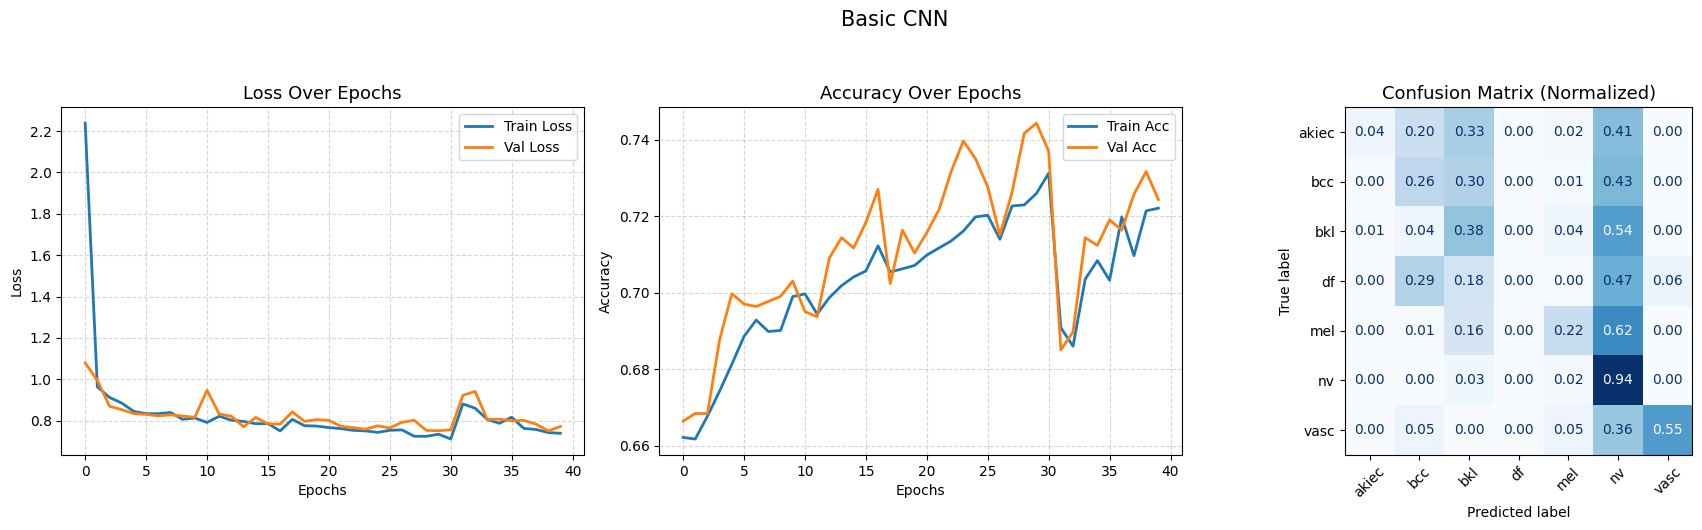

In [ ]:
plot_training_summary(history, model, test_gen, title="Basic CNN", normalize=True)

In [ ]:
Class_rep(test_gen, model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       akiec       0.50      0.04      0.08        49
         bcc       0.43      0.26      0.32        77
         bkl       0.38      0.38      0.38       165
          df       0.00      0.00      0.00        17
         mel       0.57      0.22      0.32       167
          nv       0.78      0.94      0.86      1006
        vasc       0.86      0.55      0.67        22

    accuracy                           0.72      1503
   macro avg       0.50      0.34      0.37      1503
weighted avg       0.68      0.72      0.68      1503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Model 1 performance

we can see that the first model didnt exactlty achieve a good accuracy and it needed more time to learn and i believe that the number of ephocs must be increased
* Training loss and validation loss are almost identical → NOT overfitting
* underfitting as it is a weak model


# Second CNN

Now we will need to implement some changes to improve model performance:

we will normalize the data so that all our image inputs to be on the same scale and brightness level, so the model doesn’t get confused by lighting differences, camera settings, or pixel intensity ranges. And to do that we need to normalize the data during training as the augmentation is also happening during traing so we dont want the augmented data to be unnormalized.


*   **Rescaling**: divides every pixel by 255, so values go from 0 → 1
    Neural networks learn faster when numbers are small and consistent
*   **Normalization**: finds the average color and spread for each color channel
    Then it uses those to make all images have roughly:
    mean = 0, std = 1

Also we will be implementing some extra Regularization techniques such as: early stopping, L2, .

*   early stpping
*   L2
*   Weight initialization
*   bias initialization





In [ ]:
early_stop = EarlyStopping(monitor="val_loss",patience=15,mode="min",restore_best_weights=True,verbose=1)


In [ ]:

norm = Normalization(axis=-1)
x_batch, y_batch = next(train_gen)
norm.adapt(x_batch)
HE = HeNormal() # best for use with Conv/Dense layers with ReLU activations

model_2 = Sequential()

#input
model_2.add(Input(shape=(224, 224, 3)))
model_2.add(norm)


model_2.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=HE, bias_initializer='zeros'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=HE, bias_initializer='zeros'))
model_2.add(BatchNormalization())

model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(256, (3,3), activation='relu', kernel_initializer=HE, bias_initializer='zeros'))
model_2.add(BatchNormalization())

model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(512, (3,3), activation='relu', kernel_initializer=HE, bias_initializer='zeros'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2,2)))

model_2.add(GlobalAveragePooling2D())
model_2.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4), kernel_initializer=HE,
            bias_initializer='zeros'))
model_2.add(Dropout(0.3))
# output Layer
model_2.add(Dense(7))
model_2.add(Activation("softmax"))

model_2.compile(loss = "categorical_crossentropy", optimizer ="adam",metrics =['accuracy'])

history_2 = model_2.fit(train_gen,validation_data=val_gen,epochs = 150,callbacks=[early_stop])



Epoch 1/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 139s 573ms/step - accuracy: 0.6186 - loss: 1.2088 - val_accuracy: 0.6718 - val_loss: 1.5104
Epoch 2/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 526ms/step - accuracy: 0.6779 - loss: 0.9478 - val_accuracy: 0.6798 - val_loss: 0.9234
Epoch 3/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 526ms/step - accuracy: 0.6982 - loss: 0.8688 - val_accuracy: 0.7071 - val_loss: 0.8291
Epoch 4/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 525ms/step - accuracy: 0.6907 - loss: 0.8765 - val_accuracy: 0.7077 - val_loss: 0.8044
Epoch 5/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 529ms/step - accuracy: 0.6940 - loss: 0.8434 - val_accuracy: 0.7111 - val_loss: 0.8182
Epoch 6/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 529ms/step - accuracy: 0.7245 - loss: 0.7858 - val_accuracy: 0.7230 - val_loss: 0.7885
Epoch 7/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 527ms/step - accuracy: 0.7163 - loss: 0.7958 - val_accuracy: 0.7264 - val_loss: 0.7678
Epoch 8/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 527ms/step - accuracy: 

# Second CNN Plotting

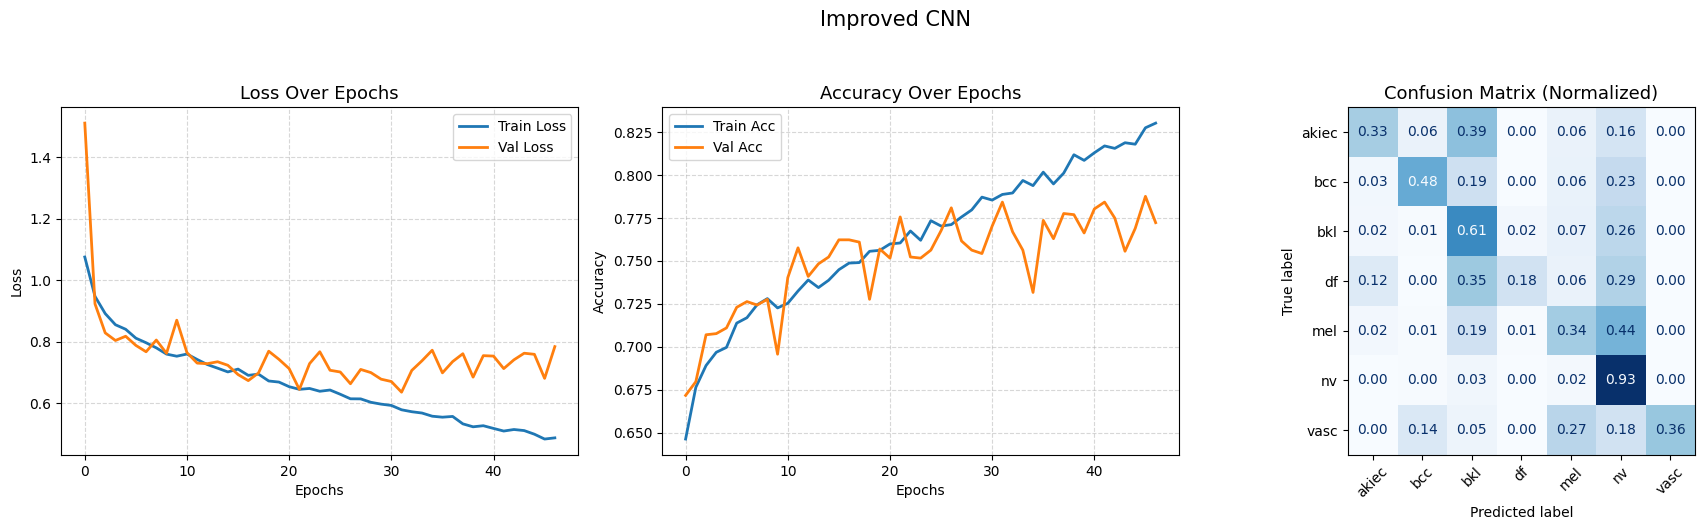

In [ ]:
plot_training_summary(history_2, model_2, test_gen, title="Improved CNN", normalize=True)

In [ ]:
Class_rep(test_gen, model_2)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       akiec       0.52      0.33      0.40        49
         bcc       0.74      0.48      0.58        77
         bkl       0.49      0.61      0.54       165
          df       0.27      0.18      0.21        17
         mel       0.53      0.34      0.41       167
          nv       0.86      0.93      0.90      1006
        vasc       1.00      0.36      0.53        22

    accuracy                           0.77      1503
   macro avg       0.63      0.46      0.51      1503
weighted avg       0.76      0.77      0.76      1503



# Model 2 performance

we can see that the accuracy is slightly better on this model but the loss is much lower due to our focus on that metric with the early stopping mechanism

# Unscaled Generator
Now we are gonna try some of the popular pre-trained models.

its important to note that those models have their own preproccessing system and they only excpect data to be proccessed in their own manners (they rescale/normalize **pixels**), thats why we can't use the original image generator we implemented above as it rescales the images, so we will create another generator that respects these model's preproccessing Dependence

In [ ]:
NoSC_train_datagen = ImageDataGenerator(
    # NOTE: no rescale here
    horizontal_flip=True,
    rotation_range=45,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode="nearest"
)

NoSC_test_datagen = ImageDataGenerator()

NoSC_train_gen = NoSC_train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="dx",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True)

NoSC_val_gen = NoSC_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="dx",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False)

NoSC_test_gen = NoSC_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="dx",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


# VGG16 Model

Next up we are gonna see how the VGG16 model faires with our data.

These models already have learned rich, generic image features from a large dataset such as ImageNet. We dont want to lose this knowledge so we freeze the Base layers to stop them from learning (no weight updates), then we train the top layers, after that is done we unfreeze some of the base layers for fine tuning.

when we recompile after unfreezing we make sure to have a slower learning rate (e.g., 1e-5) to make very gentle updates.

the model fine-tunes its higher-level features — adapting them from generic objects (edges, textures, shapes) to domain-specific features (skin lesions, pigmentation patterns, borders, etc.).

here is a table we prepared that helps summerize things:

| Step                      | Layers Trained                          | Learning Rate | Goal                                       |
| ------------------------- | --------------------------------------- | ------------- | ------------------------------------------ |
| **Freezing (Phase 1)**    | Only new Dense layers                   | 1e-4          | Learn class mapping from generic features  |
| **Fine-Tuning (Phase 2)** | Top pretrained conv layers + Dense head | 1e-5          | Refine high-level features for our dataset |

below is a demonstration to see the portion of the layers and the how they were frozen in each phase (its the MobileNetV2 model)

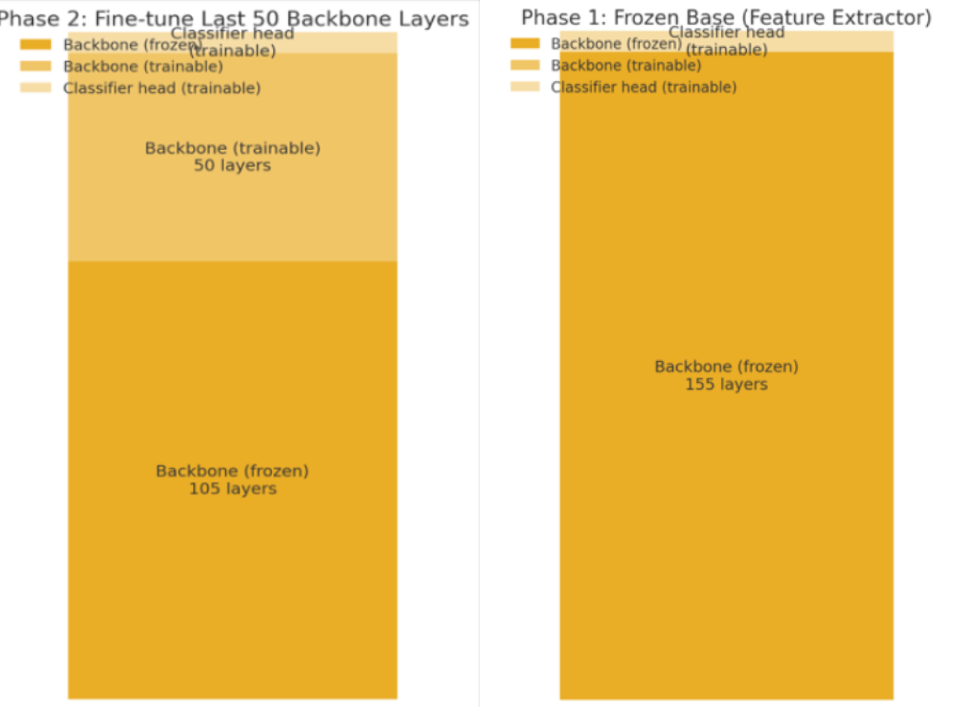

In [ ]:

vgg_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
vgg_base.trainable = False  # freeze for initial training

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Lambda(vgg_preprocess)(inputs)  # VGG16-specific preprocessing
x = vgg_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(7, activation="softmax")(x)

vgg_model = models.Model(inputs, outputs)
vgg_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_vgg = vgg_model.fit(NoSC_train_gen, validation_data=NoSC_val_gen, epochs=30, callbacks=[early_stop])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 127s 552ms/step - accuracy: 0.3733 - loss: 3.5621 - val_accuracy: 0.6205 - val_loss: 2.1161
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 522ms/step - accuracy: 0.5139 - loss: 2.7488 - val_accuracy: 0.6525 - val_loss: 1.7762
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.5302 - loss: 2.3881 - val_accuracy: 0.6558 - val_loss: 1.5987
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 519ms/step - accuracy: 0.5644 - loss: 2.1157 - val_accuracy: 0.6684 - val_loss: 1.4561
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.5956 - loss: 1.8967 - val_accuracy: 0.6764 - val_loss: 1.3342
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 524ms/step - accuracy: 0.5804 - loss: 1.8653 - val_accuracy: 0.6831 - val_loss: 1.2773
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 522ms/step - accuracy: 0.5995 - loss: 1.7380 - val_accuracy: 0.6844 - val_loss: 1.2401
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 518ms/step - accuracy: 0.6248 -

In [ ]:
# Unfreezing and retraining the model
vgg_base.trainable = True

for layer in vgg_base.layers[:-4]:   # keep all but last 4 frozen
    layer.trainable = False

vgg_model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

history_vgg_ft = vgg_model.fit(NoSC_train_gen, validation_data=NoSC_val_gen, epochs=50                                                         , callbacks=[early_stop])

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 123s 537ms/step - accuracy: 0.7141 - loss: 0.8377 - val_accuracy: 0.7377 - val_loss: 0.7076
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 522ms/step - accuracy: 0.7326 - loss: 0.7217 - val_accuracy: 0.7643 - val_loss: 0.6629
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 524ms/step - accuracy: 0.7606 - loss: 0.6425 - val_accuracy: 0.7843 - val_loss: 0.6126
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 522ms/step - accuracy: 0.7838 - loss: 0.5888 - val_accuracy: 0.7896 - val_loss: 0.5593
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 522ms/step - accuracy: 0.7937 - loss: 0.5722 - val_accuracy: 0.8009 - val_loss: 0.5846
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.8047 - loss: 0.5263 - val_accuracy: 0.8043 - val_loss: 0.5274
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.8131 - loss: 0.5027 - val_accuracy: 0.8043 - val_loss: 0.5228
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 524ms/step - accuracy: 0.8264 -

# VGG16 Plotting

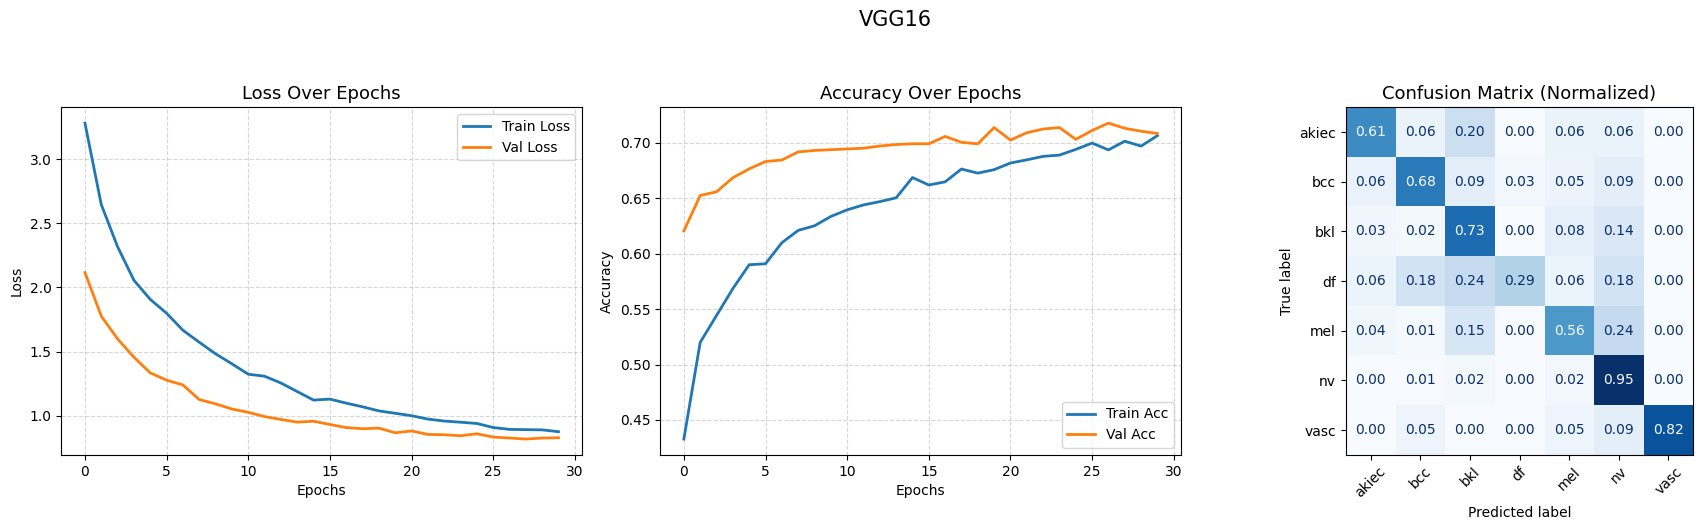

In [ ]:
plot_training_summary(history_vgg, vgg_model, NoSC_test_gen, title="VGG16", normalize=True)

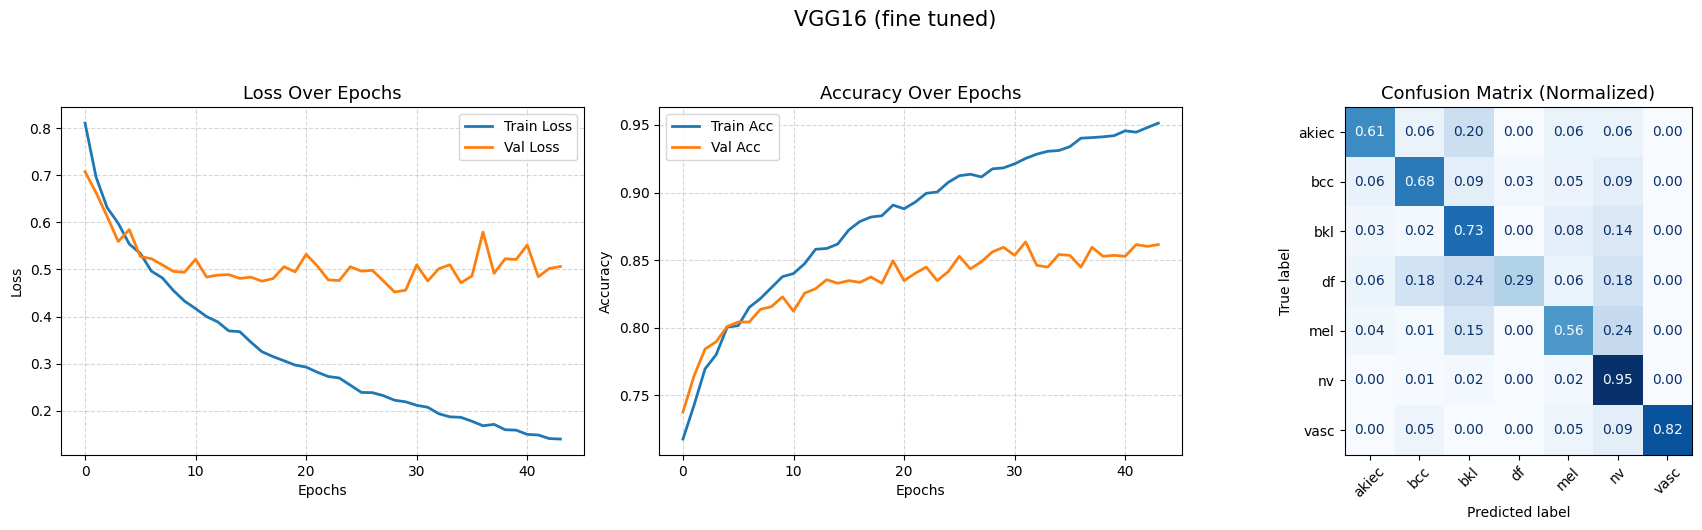

In [ ]:
plot_training_summary(history_vgg_ft, vgg_model, NoSC_test_gen, title="VGG16 (fine tuned)", normalize=True)

In [ ]:
Class_rep(NoSC_test_gen, vgg_model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       akiec       0.62      0.61      0.62        49
         bcc       0.73      0.68      0.70        77
         bkl       0.64      0.73      0.68       165
          df       0.71      0.29      0.42        17
         mel       0.66      0.56      0.61       167
          nv       0.92      0.95      0.93      1006
        vasc       1.00      0.82      0.90        22

    accuracy                           0.84      1503
   macro avg       0.76      0.66      0.69      1503
weighted avg       0.84      0.84      0.84      1503



# VGG19 Model

In [ ]:
vgg19_base = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
vgg19_base.trainable = False  # freeze for initial training


inputs = layers.Input(shape=(224, 224, 3))
x = layers.Lambda(vgg19_preprocess)(inputs)
x = vgg19_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(7, activation="softmax")(x)

vgg19_model = models.Model(inputs, outputs)
vgg19_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_vgg19 = vgg19_model.fit(NoSC_train_gen, validation_data=NoSC_val_gen, epochs=50, callbacks=[early_stop])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 120s 533ms/step - accuracy: 0.2897 - loss: 3.9288 - val_accuracy: 0.5473 - val_loss: 1.8994
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 525ms/step - accuracy: 0.4816 - loss: 2.7602 - val_accuracy: 0.6178 - val_loss: 1.6668
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 523ms/step - accuracy: 0.5382 - loss: 2.2386 - val_accuracy: 0.6352 - val_loss: 1.5372
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 531ms/step - accuracy: 0.5580 - loss: 2.0614 - val_accuracy: 0.6591 - val_loss: 1.4570
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.5827 - loss: 1.8955 - val_accuracy: 0.6585 - val_loss: 1.3784
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 522ms/step - accuracy: 0.5992 - loss: 1.7464 - val_accuracy: 0.6678 - val_loss: 1.3185
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.6099 - loss: 1.5823 - val_accuracy: 0.6711 - val_loss: 1.2551
Epoch 8/50
220/220 ━━━━━━

In [ ]:
# Unfreezing and retraining the model
vgg19_base.trainable = True

for layer in vgg_base.layers[:-4]:
    layer.trainable = False

vgg19_model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

history_vgg19_ft = vgg_model.fit(NoSC_train_gen, validation_data=NoSC_val_gen, epochs=50, callbacks=[early_stop])

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.9189 - loss: 0.2159 - val_accuracy: 0.8502 - val_loss: 0.4696
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.9202 - loss: 0.2160 - val_accuracy: 0.8569 - val_loss: 0.4491
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.9366 - loss: 0.1861 - val_accuracy: 0.8529 - val_loss: 0.5044
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 523ms/step - accuracy: 0.9270 - loss: 0.1965 - val_accuracy: 0.8475 - val_loss: 0.5080
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 522ms/step - accuracy: 0.9311 - loss: 0.1930 - val_accuracy: 0.8655 - val_loss: 0.4790
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 523ms/step - accuracy: 0.9353 - loss: 0.1813 - val_accuracy: 0.8688 - val_loss: 0.4709
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 520ms/step - accuracy: 0.9356 - loss: 0.1748 - val_accuracy: 0.8455 - val_loss: 0.5416
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 528ms/step - accuracy: 0.9346 -

# VGG19 plotting

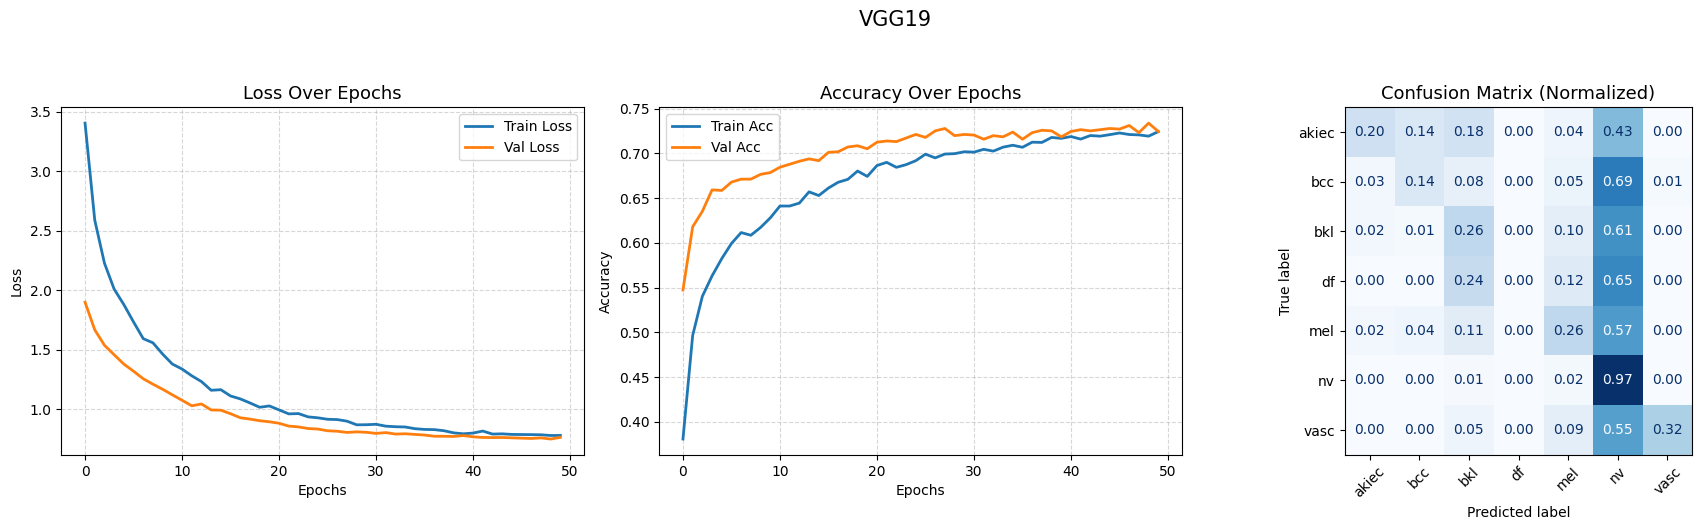

In [ ]:
plot_training_summary(history_vgg19, vgg19_model, NoSC_test_gen, title="VGG19", normalize=True)

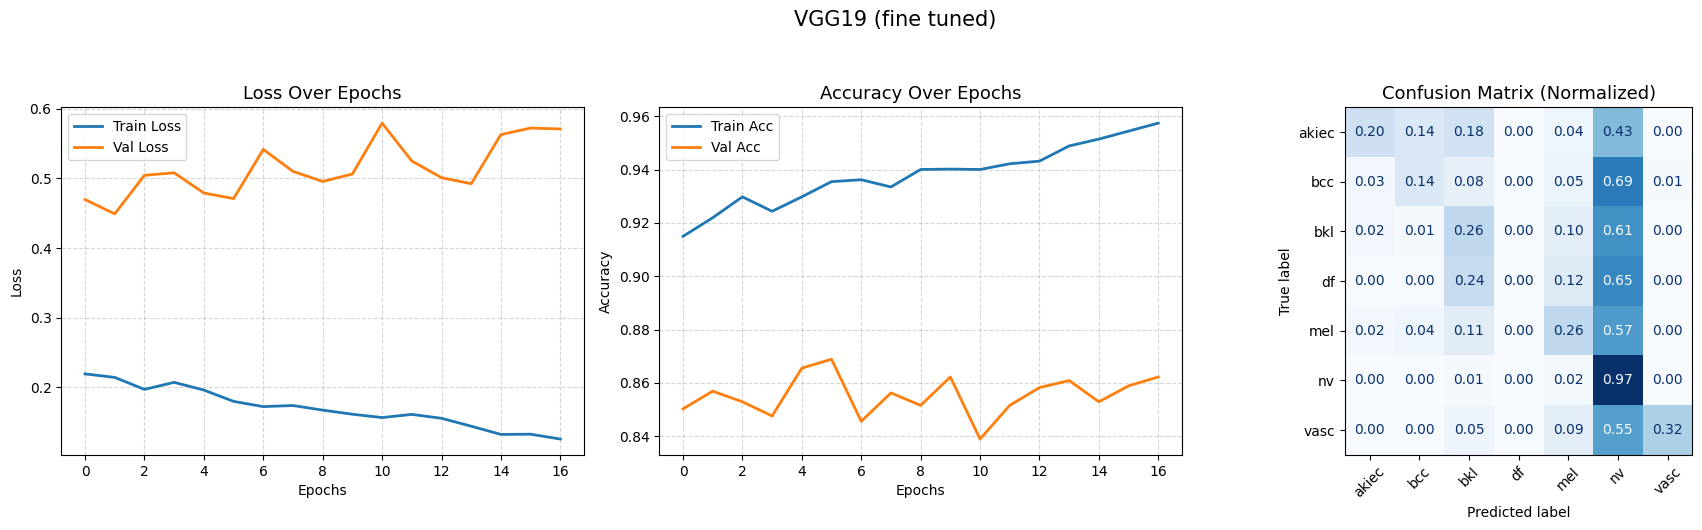

In [ ]:
plot_training_summary(history_vgg19_ft, vgg19_model, NoSC_test_gen, title="VGG19 (fine tuned)", normalize=True)

In [ ]:
Class_rep(NoSC_test_gen,vgg19_model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       akiec       0.50      0.20      0.29        49
         bcc       0.37      0.14      0.21        77
         bkl       0.47      0.26      0.33       165
          df       0.00      0.00      0.00        17
         mel       0.50      0.26      0.34       167
          nv       0.77      0.97      0.86      1006
        vasc       0.88      0.32      0.47        22

    accuracy                           0.72      1503
   macro avg       0.50      0.31      0.36      1503
weighted avg       0.67      0.72      0.68      1503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ResNet50V2
Now we are gonna implement the ResNet34 model and see how it handels the data.



In [ ]:
# ResNet34 backbone (no top classifier)
resnet50v2_base = ResNet50V2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
resnet50v2_base.trainable = False  # freeze pretrained layers initially

# Model head
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Lambda(resnet50v2_preprocess)(inputs)   # ResNet preprocessing
x = resnet50v2_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(7, activation="softmax")(x)

resnet50v2_model = models.Model(inputs, outputs)
resnet50v2_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_resnet50v2 = resnet50v2_model.fit(NoSC_train_gen, validation_data=NoSC_val_gen, epochs=50, callbacks=[early_stop])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 141s 592ms/step - accuracy: 0.4069 - loss: 1.9090 - val_accuracy: 0.6771 - val_loss: 1.0856
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.6538 - loss: 1.1519 - val_accuracy: 0.6824 - val_loss: 0.9793
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.6585 - loss: 1.0625 - val_accuracy: 0.6897 - val_loss: 0.9160
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.6765 - loss: 0.9818 - val_accuracy: 0.6964 - val_loss: 0.8755
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.6835 - loss: 0.9327 - val_accuracy: 0.7017 - val_loss: 0.8353
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 527ms/step - accuracy: 0.6907 - loss: 0.9055 - val_accuracy: 0.7071 - val_loss: 0.8140
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.6887 - loss: 0.8787 - val_accuracy: 0.7157 - val_loss: 0.7818
Epoch 8/50
220/220 ━━━━━━

Next we unfreeze the layers so that the model can fine-tune it self

In [ ]:
# Unfreeze the base
resnet50v2_base.trainable = True

# Freeze most layers, fine-tune top ones
for layer in resnet50v2_base.layers[:-50]:
    layer.trainable = False

# Recompile with a lower learning rate
resnet50v2_model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

# Fine-tune training
history_resnet50v2_ft = resnet50v2_model.fit(NoSC_train_gen, validation_data=NoSC_val_gen, epochs=50, callbacks=[early_stop])

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 150s 586ms/step - accuracy: 0.6825 - loss: 0.8710 - val_accuracy: 0.7563 - val_loss: 0.6936
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 524ms/step - accuracy: 0.7446 - loss: 0.6976 - val_accuracy: 0.7723 - val_loss: 0.6468
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 531ms/step - accuracy: 0.7615 - loss: 0.6427 - val_accuracy: 0.7770 - val_loss: 0.6214
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 527ms/step - accuracy: 0.7817 - loss: 0.6095 - val_accuracy: 0.7909 - val_loss: 0.5925
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.7940 - loss: 0.5447 - val_accuracy: 0.7976 - val_loss: 0.5757
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.7989 - loss: 0.5346 - val_accuracy: 0.8029 - val_loss: 0.5633
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.8071 - loss: 0.5078 - val_accuracy: 0.8116 - val_loss: 0.5426
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 519ms/step - accuracy: 0.8226 -

# ResNet50V2 Plotting

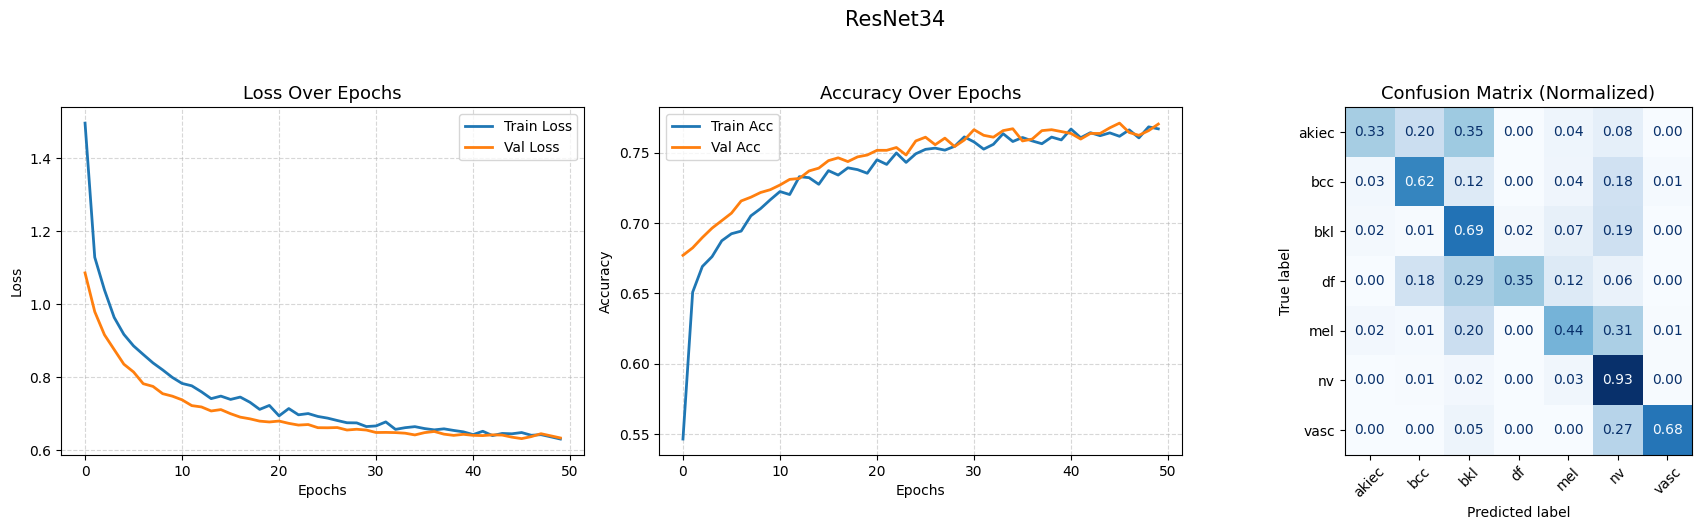

In [ ]:
plot_training_summary(history_resnet50v2, resnet50v2_model, NoSC_test_gen, title="ResNet34", normalize=True)

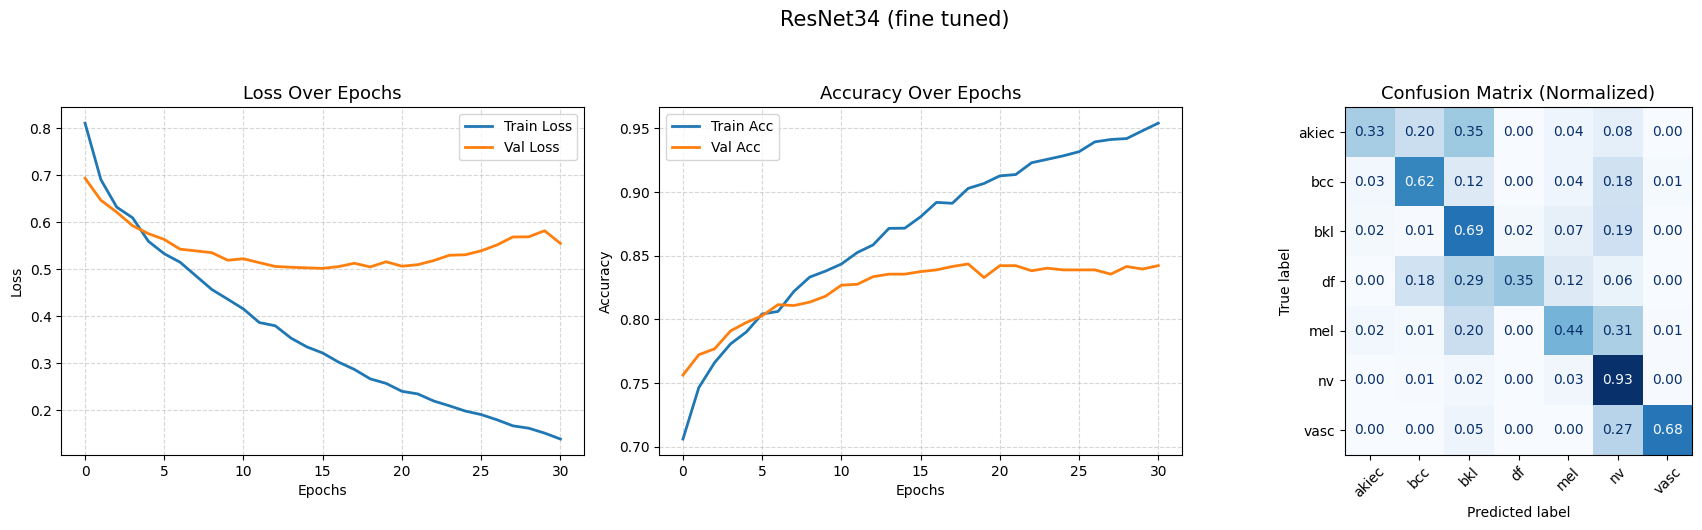

In [ ]:
plot_training_summary(history_resnet50v2_ft, resnet50v2_model, NoSC_test_gen, title="ResNet34 (fine tuned)", normalize=True)

In [ ]:
Class_rep(NoSC_test_gen,resnet50v2_model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       akiec       0.64      0.33      0.43        49
         bcc       0.69      0.62      0.65        77
         bkl       0.56      0.69      0.62       165
          df       0.55      0.35      0.43        17
         mel       0.59      0.44      0.51       167
          nv       0.90      0.93      0.91      1006
        vasc       0.68      0.68      0.68        22

    accuracy                           0.80      1503
   macro avg       0.66      0.58      0.60      1503
weighted avg       0.80      0.80      0.80      1503



# MobileNetV2

We Chose the V2 because its light-weight and more optimal for our environment and data

In [ ]:
mbv2_base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
mbv2_base.trainable = False  # freeze for the first phase

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Lambda(mbv2_preprocess)(inputs)
x = mbv2_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(7, activation="softmax")(x)

mbv2_model = models.Model(inputs, outputs)
mbv2_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_mbv2 = mbv2_model.fit(NoSC_train_gen, validation_data=NoSC_val_gen, epochs=50, callbacks=[early_stop])

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 175s 690ms/step - accuracy: 0.3535 - loss: 2.0940 - val_accuracy: 0.6804 - val_loss: 1.0677
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 520ms/step - accuracy: 0.6369 - loss: 1.2086 - val_accuracy: 0.6884 - val_loss: 0.9581
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 521ms/step - accuracy: 0.6584 - loss: 1.0942 - val_accuracy: 0.6984 - val_loss: 0.9263
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 518ms/step - accuracy: 0.6697 - loss: 1.0413 - val_accuracy: 0.7051 - val_loss: 0.8673
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.6626 - loss: 1.0045 - val_accuracy: 0.7130 - val_loss: 0.8379
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.6770 - loss: 0.9389 - val_accuracy: 0.7177 - val_loss: 0.8067
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 523ms/step - accuracy: 0.6849 - loss: 0.9402 - val_accuracy: 0.7204 - val_loss: 0.7988
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 520ms/step - accuracy: 0.7015 -

In [ ]:
mbv2_base.trainable = True

for layer in mbv2_base.layers[:-50]:   # fine-tune only last 50 layers
    layer.trainable = False

mbv2_model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

# Fine-tune training
history_mbv2_ft = mbv2_model.fit(NoSC_train_gen, validation_data=NoSC_val_gen, epochs=20, callbacks=[early_stop])

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 151s 595ms/step - accuracy: 0.6772 - loss: 0.9073 - val_accuracy: 0.7324 - val_loss: 0.8095
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 518ms/step - accuracy: 0.7089 - loss: 0.8170 - val_accuracy: 0.7304 - val_loss: 0.8360
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 518ms/step - accuracy: 0.7424 - loss: 0.7267 - val_accuracy: 0.7397 - val_loss: 0.8294
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 518ms/step - accuracy: 0.7470 - loss: 0.7104 - val_accuracy: 0.7523 - val_loss: 0.8005
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 519ms/step - accuracy: 0.7475 - loss: 0.6728 - val_accuracy: 0.7577 - val_loss: 0.7475
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 516ms/step - accuracy: 0.7638 - loss: 0.6506 - val_accuracy: 0.7816 - val_loss: 0.6796
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 113s 515ms/step - accuracy: 0.7723 - loss: 0.6313 - val_accuracy: 0.7843 - val_loss: 0.6604
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 519ms/step - accuracy: 0.7725 -

# MobileNetV2 Plotting

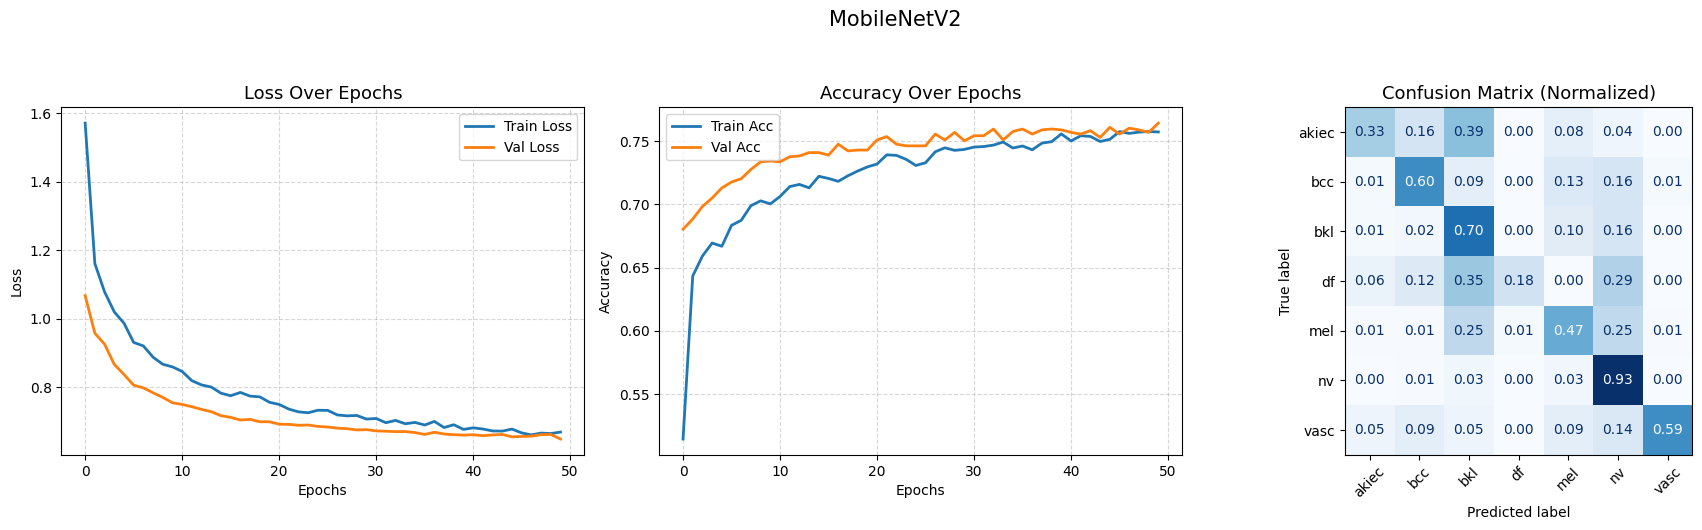

In [ ]:
plot_training_summary(history_mbv2, mbv2_model, NoSC_test_gen, title="MobileNetV2", normalize=True)

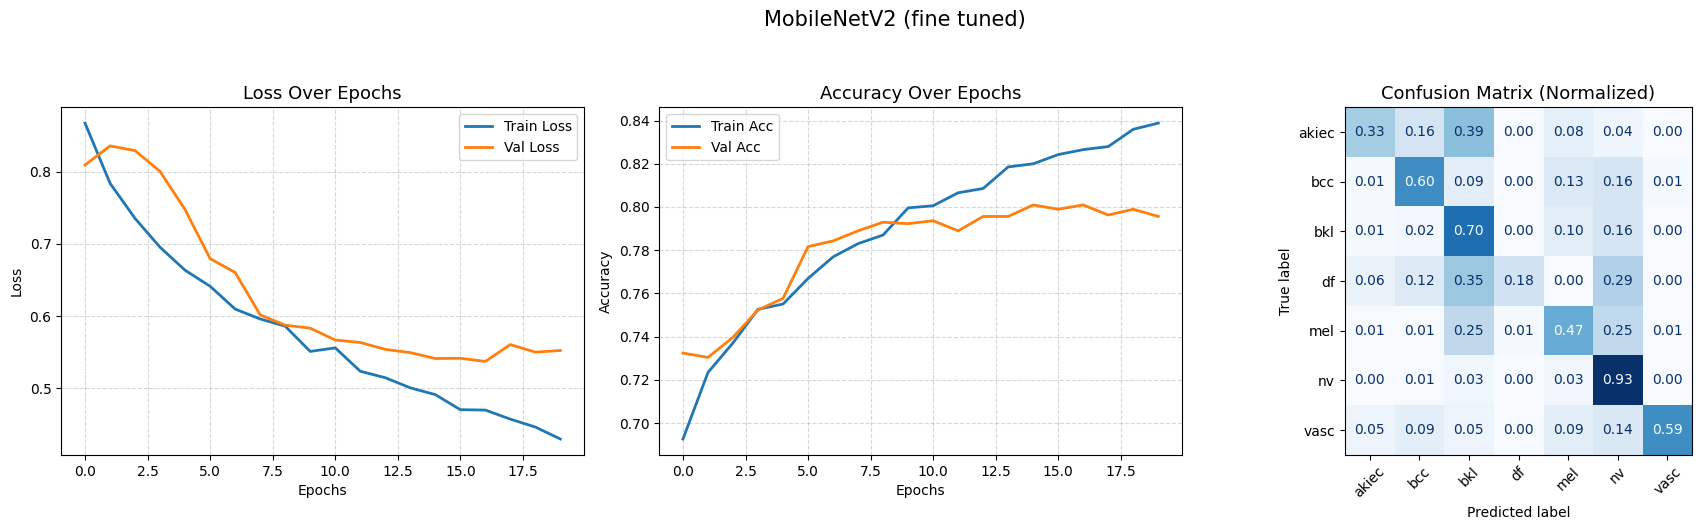

In [ ]:
plot_training_summary(history_mbv2_ft, mbv2_model, NoSC_test_gen, title="MobileNetV2 (fine tuned)", normalize=True)

In [ ]:
Class_rep(NoSC_test_gen, mbv2_model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       akiec       0.73      0.33      0.45        49
         bcc       0.67      0.60      0.63        77
         bkl       0.52      0.70      0.60       165
          df       0.50      0.18      0.26        17
         mel       0.55      0.47      0.51       167
          nv       0.91      0.93      0.92      1006
        vasc       0.81      0.59      0.68        22

    accuracy                           0.80      1503
   macro avg       0.67      0.54      0.58      1503
weighted avg       0.80      0.80      0.80      1503



# Evaluation
Alright now to put things into perspective we need to have a clear evalutaion method that compares our models, ranks them, and chooses the best one and saves it.

In [ ]:
# put the evalutaion into a function for repetetion
def eval_model(model, test_gen, val_gen):
    y_true = test_gen.classes
    y_prob = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    params = model.count_params()
    val_loss, _ = model.evaluate(val_gen, verbose=0)

    return acc, f1m, params, val_loss


results = []

models_list = [
    ("First CNN",    model,           test_gen,      val_gen),
    ("Second CNN",   model_2,         test_gen,      val_gen),
    ("ResNet50V2",   resnet50v2_model, NoSC_test_gen, NoSC_val_gen),
    ("VGG16",        vgg_model,       NoSC_test_gen, NoSC_val_gen),
    ("VGG19",        vgg19_model,     NoSC_test_gen, NoSC_val_gen),
    ("MobileNetV2",  mbv2_model,      NoSC_test_gen, NoSC_val_gen)]

for name, m, test_g, val_g in models_list:
    acc, f1m, params, val_loss = eval_model(m, test_g, val_g)
    results.append((name, acc, f1m, params, val_loss, m))


df_results = pd.DataFrame(results, columns=["Model", "Test Accuracy", "Macro-F1", "Params", "Val Loss", "Obj"])


df_sorted = df_results.sort_values(by=["Test Accuracy", "Val Loss"], ascending=[False, True])

# ranking from best to worst
print("\nModel ranking (best → worst):")
print(df_sorted[["Model", "Test Accuracy", "Macro-F1", "Params", "Val Loss"]])


best_row = df_sorted.iloc[0]
best_name = best_row["Model"]
best_model = best_row["Obj"]

save_path = f"best_model_{best_name}.keras"
best_model.save(save_path)

print(f"\nBest model: {best_name}")
print(f"Saved to: {save_path}")



Model ranking (best → worst):
         Model  Test Accuracy  Macro-F1    Params  Val Loss
3        VGG16       0.857618  0.720115  14718279  0.449053
2   ResNet50V2       0.804391  0.604525  23579143  0.501856
5  MobileNetV2       0.802395  0.578640   2266951  0.537109
1   Second CNN       0.772455  0.511804   1687950  0.636504
4        VGG19       0.724551  0.356368  20027975  0.748155
0    First CNN       0.719228  0.373795  95629191  0.771475

Best model: VGG16
Saved to: best_model_VGG16.keras


In [ ]:
files.download('best_model_VGG16.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#